In [1]:
#Clustering and RANSAC for WDD2017 paper
#Fernando Wario
#June 2017

%matplotlib notebook

import csv
import cv2
import datetime
import glob
import json
import math
import numpy as np
import os
import pandas
import sys
import scipy.cluster
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn.linear_model import TheilSenRegressor
from skimage.transform import radon, rescale
from scipy.stats import multivariate_normal
from scipy import stats

sys.path.append('../functions/')
sys.path.append('../utils/')

#Radian
radi = 180/np.pi

In [11]:
#Decoder data is loaded
#DECODER DATA
#Path to the Decoder data
inputFile = '../Data/GTRuns_decoder.csv'
A = {}
DecFile = open(inputFile, 'rt', encoding='utf-8-sig')
for row in csv.reader(DecFile, delimiter = ','):
    key = row[0]
    #duration of the WRun in ms
    length_ms = float(row[1])*10
    #Time is splitted    
    split_time = row[6].split(":")
    #Timestamp to seconds, disregard miliseconds
    time_sec = int(split_time[0])*3600 + int(split_time[1])*60 + int(split_time[2])
    A[key] = [length_ms, row[2], row[3], row[4], time_sec, split_time[0], split_time[1]]
print('done with DecArray!')
print(A)

done with DecArray!
{'20160814_1007_1/15': [230.0, '0.186615995292', '109.9', '83.3', 36470, '10', '07'], '20160814_1007_1/6': [800.0, '0.524471999883', '101.5', '87.5', 36452, '10', '07'], '20160814_1002_1/8': [710.0, '4.16714201776', '66.0', '89.6', 36127, '10', '02'], '20160814_1028_1/2': [1070.0, '0.725706235335', '95.1', '30.2', 37696, '10', '28'], '20160814_1004_1/6': [440.0, '5.97242106525', '98.5', '115.3', 36279, '10', '04'], '20160814_1022_1/2': [580.0, '0.114101695085', '92.6', '64.4', 37344, '10', '22'], '20160814_1003_1/4': [640.0, '3.9022368969', '100.3', '49.0', 36191, '10', '03'], '20160814_1007_1/10': [650.0, '0.686922935226', '105.6', '83.8', 36457, '10', '07'], '20160814_1004_1/5': [460.0, '5.96177927463', '96.7', '115.1', 36279, '10', '04'], '20160814_1008_1/12': [230.0, '3.70818015339', '78.8', '51.4', 36507, '10', '08'], '20160814_1002_1/27': [440.0, '3.54031148674', '108.4', '51.0', 36171, '10', '02'], '20160814_1023_1/13': [590.0, '0.314251536692', '64.0', '103.

In [17]:
#Load X0, Y0 and Timestamp to B
B = np.array([[float(A[key][2]), float(A[key][3]), float(A[key][4])] for key in A])
print(B.shape)
#Generate the linkage matrix
Z = scipy.cluster.hierarchy.linkage(B, 'ward')
print(Z.shape)
#print(Z)
#print(B)

(200, 3)
(199, 4)


<IPython.core.display.Javascript object>


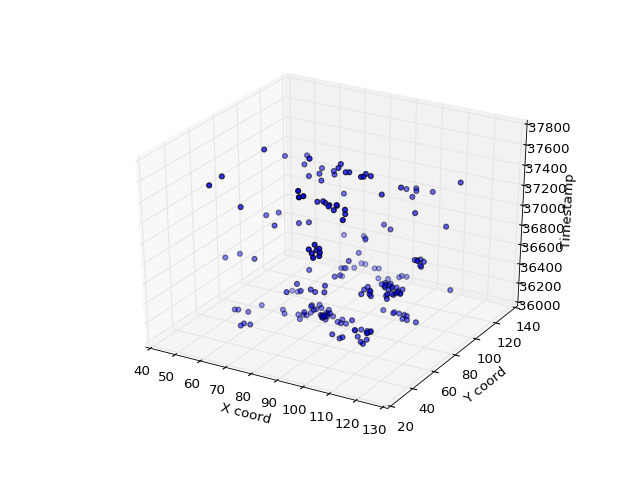

In [18]:
#3D scatterplot
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(B[:,0], B[:,1], B[:,2], c='b', marker = 'o')

ax.set_xlabel('X coord')
ax.set_ylabel('Y coord')
ax.set_zlabel('Timestamp')

plt.show()

<IPython.core.display.Javascript object>


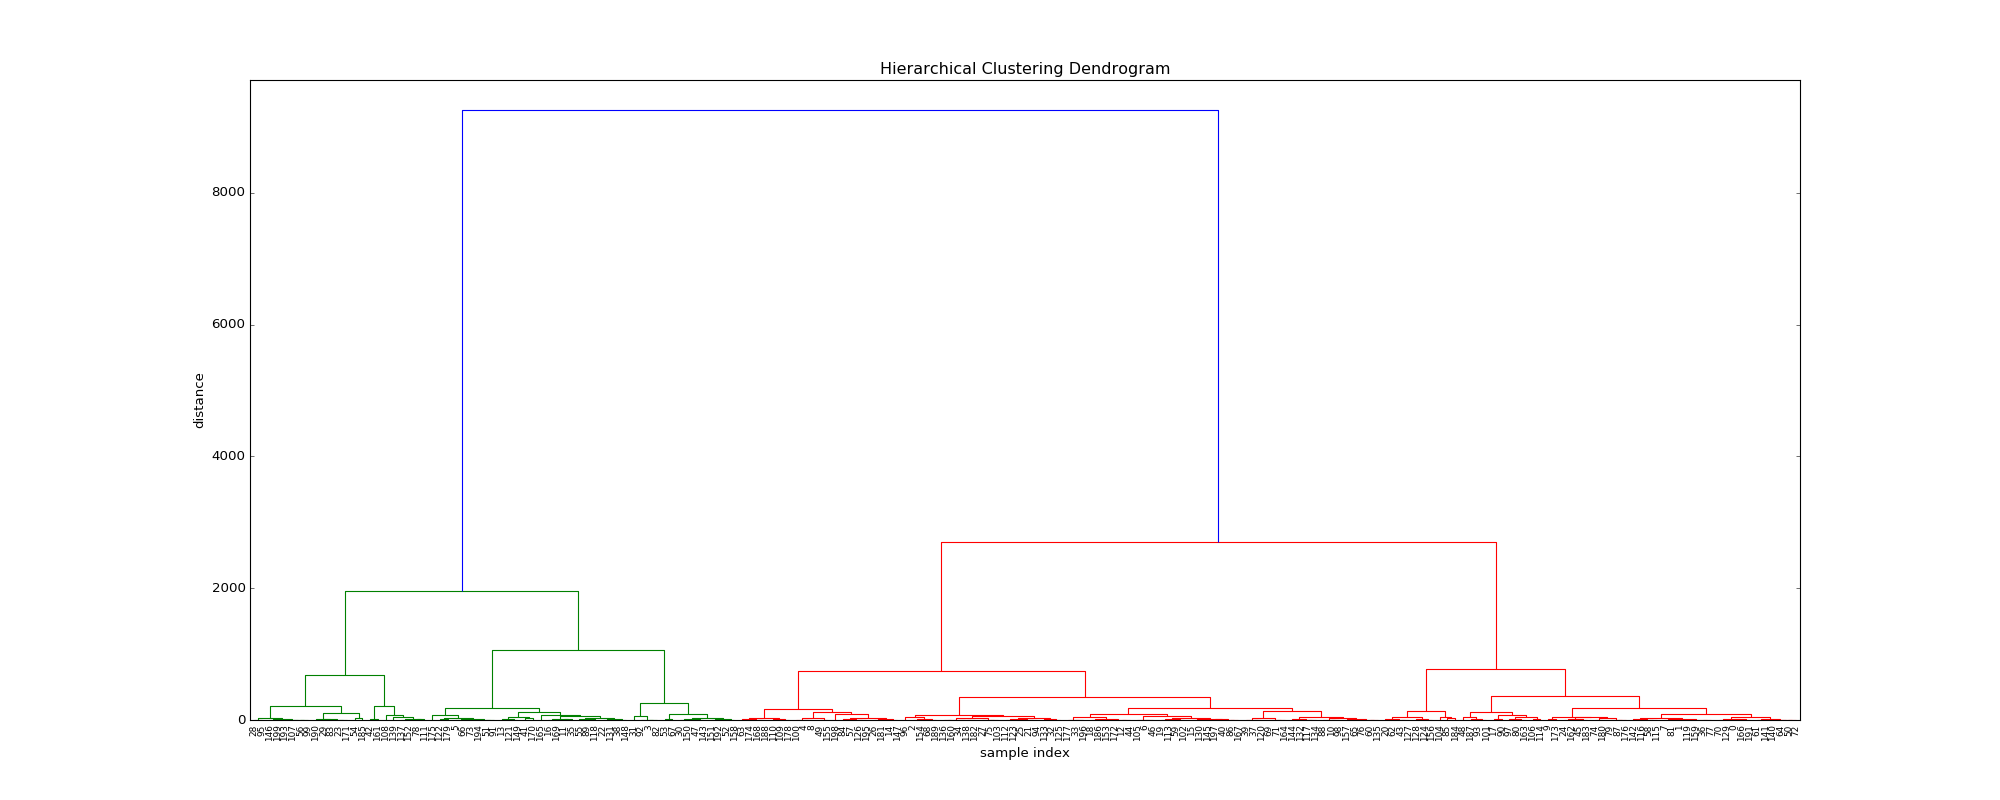

In [19]:
#Calculate full dendrogram
fig2 = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
scipy.cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

<IPython.core.display.Javascript object>


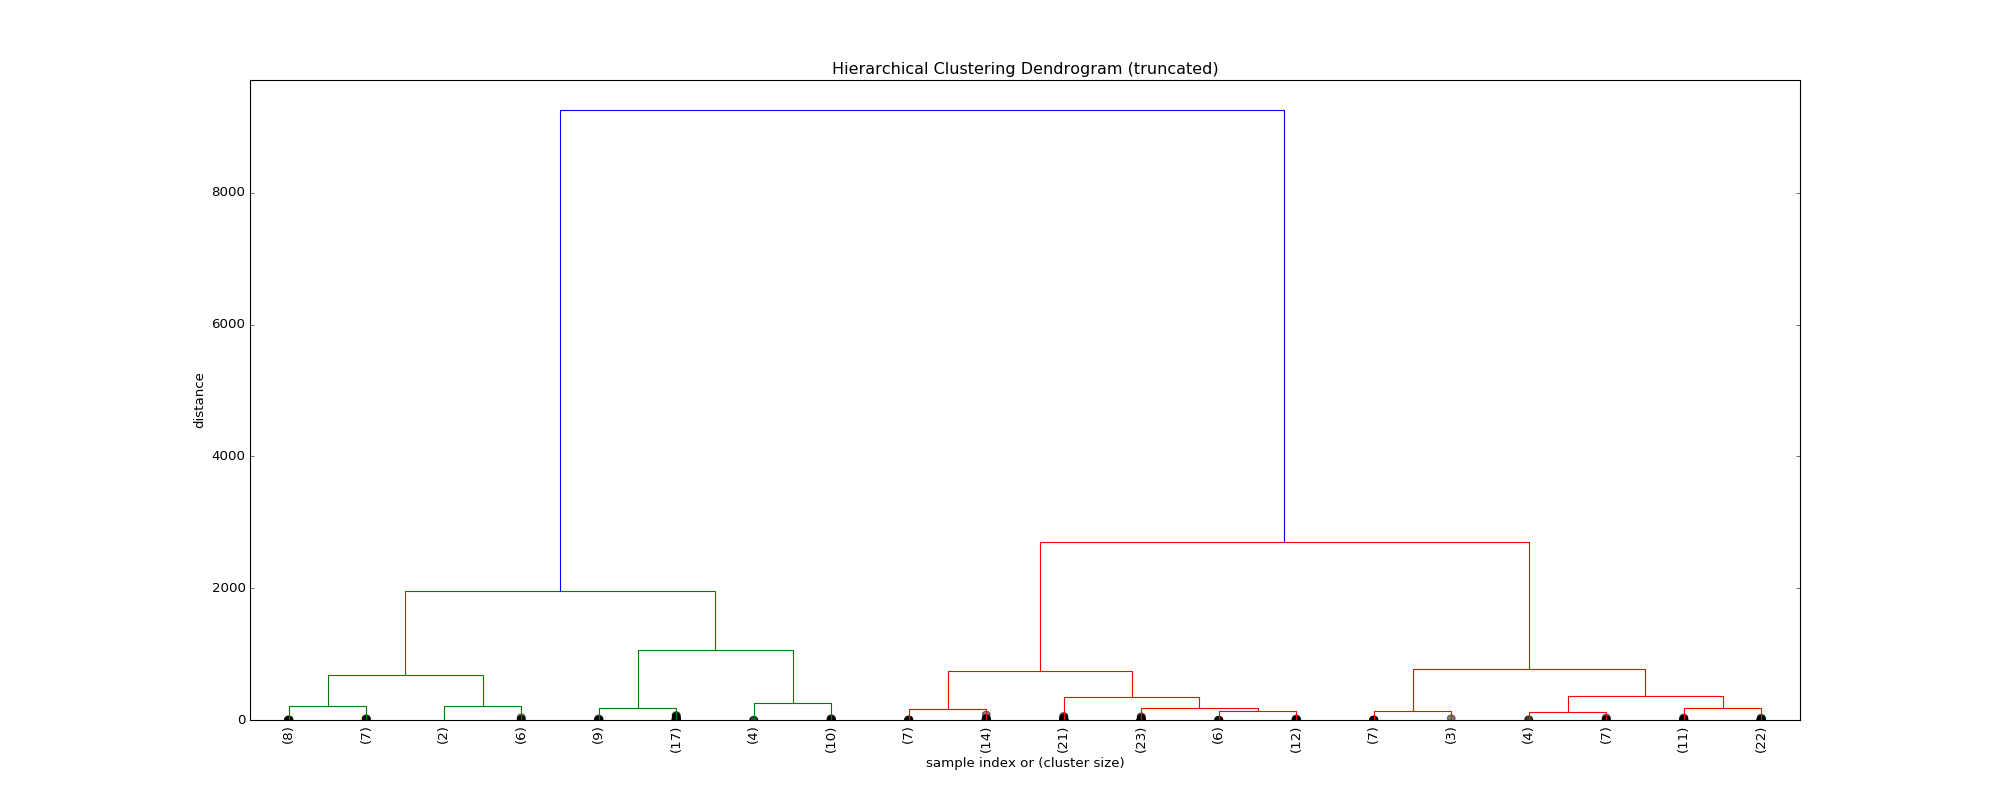

In [20]:
fig3 = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
scipy.cluster.hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [21]:
max_d = 100
clusters = scipy.cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
clusters

array([23, 23, 14,  9, 12,  6, 15, 23, 12, 22, 17,  8, 15,  7, 13, 15,  8,
       21, 15, 15, 18, 14,  8,  2, 22, 14, 13, 14,  1,  2, 10,  9, 14, 15,
       14,  8, 23, 16,  8, 16, 15,  7,  4, 18, 15, 22, 15, 10, 20, 12, 23,
        6, 10, 10,  3,  8,  1, 13, 23, 15, 17, 23, 18, 11, 23, 17,  6, 10,
       14, 16, 23, 16, 23,  6, 22, 14, 17, 23,  5, 22, 21, 23,  9,  2, 13,
       19, 15, 22, 17,  8, 21,  6,  9, 20, 14,  1, 14, 21, 17,  1, 12, 20,
       15, 14, 19, 15, 21,  1,  5, 11, 11,  5, 14, 15, 21, 23, 23, 17,  8,
       23, 16,  7,  6, 14, 18, 14, 13, 18, 18, 23, 15,  8, 17, 14, 17, 17,
       14,  5, 14,  5, 23, 23, 23, 10, 17, 15,  1, 13,  8,  7, 10, 10,  5,
       15, 14, 12, 18, 17, 10, 23, 14,  4, 22, 21, 16,  8, 23, 15, 11,  8,
        7,  2, 15, 22, 11,  6, 22, 15, 11,  6, 22, 13, 14, 22, 19,  3, 15,
       20, 11, 14,  2, 23, 10,  1,  6, 13, 15, 15, 13,  1], dtype=int32)

<IPython.core.display.Javascript object>


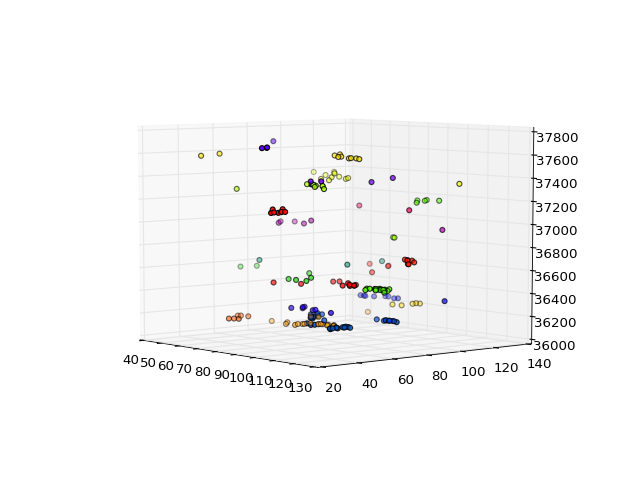

In [24]:
fig4 = plt.figure()
bx = fig4.add_subplot(111, projection='3d')
# plot points with cluster dependent colors
bx.scatter(B[:,0], B[:,1], B[:,2], c=clusters, cmap='prism')
plt.show()